In [1]:
using PorousMaterials # Pkg.clone("https://github.com/SimonEnsemble/PorousMaterials.jl", "v0.1.1")
using CSV
using DataFrames
using TSne
using PyCall
@pyimport adjustText
using PyPlot
using DelimitedFiles
using LinearAlgebra
using Printf
using Random
using Optim
using CoherentPointDrift # https://github.com/SimonEnsemble/CoherentPointDrift.jl

Cage database CDB41 (41 cages) from [here](https://github.com/marcinmiklitz/CDB41). Cleaned of solvent. Thanks to Kim Jelfs and M. Miklitz for kindly providing the cages.

Reference:
> M. Miklitz, S. Jiang, R. Clowes, M. E. Briggs, A. I. Cooper and K. E. Jelfs, Computational Screening of Porous Organic Molecules for Xenon/Krypton Separation, J. Phys. Chem. C, 2017. DOI: 10.1021/acs.jpcc.7b03848

Other set of 33 cages from the .xyz files deposited as ESI of DOI 10.1038/s41467-018-05271-9

> R. L. Greenaway, V. Santolini, M. J. Bennison, B. M. Alston, C. J. Pugh, M. A. Little, M. Miklitz, E. G. B. Eden-Rump, R. Clowes, A. Shakil, H. J. Cuthbertson, H. Armstrong, M. E. Briggs, K. E. Jelfs & A. I. Cooper. High-throughput discovery of organic cages and catenanes using computational screening fused with robotic synthesis. Nature Communications, 2018. DOI: 10.1038/s41467-018-05271-9
                                                              
I manually looked at Fig 4 in the main text and selected those that were synthesized. Some cages required visualization to compare to Fig 4 since e.g. there are multiple versions of B23, a few of which were apparently not synthesized but only computational predictions.

The `.xyz` files describing the molecular structure of all of these cages are in the directory `all_cages`.

In [2]:
cages = readdlm("all_cages/all_cages.txt")
cages[1]

"A11"

## Center and align cages for comparison
The center of mass will be set to be the origin.
Each cage will be rotated such that it is aligned with its principle moments of inertia.
i.e. the moment of inertia matrix of an "aligned" cage is diagonal.


First, a function to compute the center of mass of a group of `atoms` at Cartesian coordinates `x`, stored in the columns.

In [3]:
function center_of_mass(atoms::Array{Symbol, 1}, x::Array{Float64, 2})
    ams = read_atomic_masses()
    com = [0.0, 0.0, 0.0]
    total_mass = 0.0
    for (i, atom) in enumerate(atoms)
        com += ams[atom] * x[:, i]
        total_mass += ams[atom]
    end
    return com / total_mass
end

center_of_mass (generic function with 1 method)

A function to read in the raw `.xyz` file containing coordinates of a cage molecule, compute the center of mass, and translate the entire cage molecule such that its center of mass lays at the origin.

In [4]:
function centered_cage_coords(cage::AbstractString)
    # read in raw .xyz from `all_cages`
    atoms, x = read_xyz("all_cages/$cage.xyz")
    
    # compute center of mass
    x_com = center_of_mass(atoms, x)
    
    # shift coords so that cage is centered
    x = x .- x_com
    
    return atoms, x
end

centered_cage_coords (generic function with 1 method)

Next, a function to compute the moment of inertia matrix of a group of `atoms` at Cartesian positions `x`. 

See <a href="https://chem.libretexts.org/Textbook_Maps/Physical_and_Theoretical_Chemistry_Textbook_Maps/Map%3A_Physical_Chemistry_(McQuarrie_and_Simon)/13%3A_Molecular_Spectroscopy/13-08._The_Rotational_Spectrum_of_a_Polyatomic_Molecule_Depends_Upon_the_Principal_Moments_of_Inertia_of_the_Molecule">Chemistry Libre Texts</a> moment of inertia formulas.

In [5]:
function moment_of_inertia(atoms::Array{Symbol, 1}, x::Array{Float64, 2})
    @assert(isapprox(center_of_mass(atoms, x), [0.0, 0.0, 0.0], atol=0.0001),
        "cage must be centered to compute moment of inertia matrix!")
    
    # read in atomic masses
    ams = read_atomic_masses()
    
    # moment of inertia matrix `mi`
    mi = zeros(Float64, 3, 3)
    for i = 1:3
        for j = 1:3
            for (a, atom) in enumerate(atoms)
                if i == j
                    ids = collect(setdiff(Set([1, 2, 3]), Set([i])))
                    mi[i, j] += ams[atom] * sum(x[ids, a] .^ 2)
                else
                    mi[i, j] -= ams[atom] * x[i, a] * x[j, a]
                end
            end
        end
    end
    
    # should be symmetric!
    @assert isapprox(mi, mi')
        
    return mi
end

# simple test for diatomic molecule with atoms at [1, 0, 0], [-1, 0, 0]
@assert isapprox(
        moment_of_inertia([:C, :C], hcat([1.0, 0.0, 0.0], [-1.0, 0.0, 0.0])), 
        diagm(0 => [0.0, read_atomic_masses()[:C] / 2.0 * 4, read_atomic_masses()[:C] / 2.0 * 4]))
# simple test for a three-blade propeller. 
# see pg. 12 https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-07-dynamics-fall-2009/lecture-notes/MIT16_07F09_Lec26.pdf
@assert isapprox(
        moment_of_inertia([:O, :O, :O], 
                          hcat([0.0, 1.0, 0.0], [-sqrt(3)/2, -1/2, 0.0], [sqrt(3)/2, -1/2, 0.0])), 
        diagm(0 => read_atomic_masses()[:O] * [3/2, 3/2, 3.0]))
# a random rotation of the 3-blade propeller should have equal moments of inertia
_θ = rand() * 2 * π
_R = [cos(_θ) -sin(_θ); sin(_θ) cos(_θ)]
_x_2d = _R * hcat([0.0, 1.0], [-sqrt(3)/2, -1/2], [sqrt(3)/2, -1/2])
_x = vcat(_x_2d, [0.0 0.0 0.0])
_mi = moment_of_inertia([:O, :O, :O], _x)
@assert isapprox(_mi[1, 1], _mi[2, 2])

Now a function that calls the above functions to compute the moment of inertia matrix and then diagonalize it. i.e. find its eigendecomposition. This function returns an array of the eigenvalues `λ` of the moment of inertia, along with a matrix containing its eigenvectors `v`, as well as the moment of inertia matrix itself `mi`.

In [6]:
function diagonlize_moment_of_inertia(atoms::Array{Symbol, 1}, x::Array{Float64, 2})
    @assert(isapprox(center_of_mass(atoms, x), [0.0, 0.0, 0.0], atol=0.0001),
        "cage not centered!")
  
    # compute moment of inertia matrix
    mi = moment_of_inertia(atoms, x)

    # diagnomize moment of inertia matrix
    λ, v = eigen(mi) # columns of v are eigenvectors
    
    # reorder eigenvalues and eigenvectors from large to small
    ids = sortperm(λ, rev=true) # sort eigenvalues from large to small.
    λ = λ[ids]
    v = v[:, ids] # eigenvectors in columns
    
    # tests out of paranoia
    @assert(isapprox(mi * v, v * diagm(0 => λ)), "eigenvectors not right")
    @assert(isapprox([norm(v[:, i]) for i = 1:3], ones(3)), "eigenvectors not unit vectors")
    @assert(isapprox(mi, v * diagm(0 => λ) * v'))
    # `v` is a rotation matrix b/c `mi` is symmetric and the columns are orthonormal
    # i.e. `v` is a unitary matrix. now use it to rotate x to align with principle axes of rotation
    @assert(isapprox(v' * v, Diagonal{Float64}(I, 3)), "v is not unitary...")
    @assert (λ[1] >= λ[2]) & (λ[2] >= λ[3])
    
    return λ, v, mi
end

diagonlize_moment_of_inertia (generic function with 1 method)

function to center cage, then rotate so as to align principle axes of inertia with the Cartesian axes.

In [7]:
function rotational_inertia_aligned_cage(cage::AbstractString)
    atoms, x = centered_cage_coords(cage)
    λ, v, mi = diagonlize_moment_of_inertia(atoms, x)
    
    # rotate cage so as to align it with the principle axes of inertia
    x = v' * x
    
    # now ensure its moment of inertia matrix is diagonal
    mi = moment_of_inertia(atoms, x)
    @assert(isapprox(diagm(0 => diag(mi)), mi), "not aligned with principle axes")

    # assert moments of inertia are ordered largest to smallest
    @assert(mi[1, 1] >= mi[2, 2])
    @assert(mi[2, 2] >= mi[3, 3])
    return atoms, x
end

rotational_inertia_aligned_cage (generic function with 1 method)

### Example where principal axes of inertia are degenerate.
SO$_3$ has degenerate moments of inertia and principal axes of inertia.
See [here](https://www.youtube.com/watch?v=7vt24ICeUag).

In [8]:
atoms_SO3 = [:S, :O, :O, :O]
ℓ_SO3 = 1.42 # bond length, A https://en.wikipedia.org/wiki/Sulfur_trioxide
x_SO3 = hcat([0.0, 0.0, 0.0], [-sqrt(3)/2*ℓ_SO3, -ℓ_SO3/2, 0.0], 
             [sqrt(3)/2*ℓ_SO3, -ℓ_SO3/2, 0.0], [0.0, ℓ_SO3, 0.0])
@assert isapprox(center_of_mass(atoms_SO3, x_SO3), zeros(3))
write_xyz(atoms_SO3, x_SO3, "SO3.xyz")
λ, v = eigen(moment_of_inertia(atoms_SO3, x_SO3))
println("λ of I(SO3) / ℓ_SO3^2 / m_O: ", λ / ℓ_SO3^2 / read_atomic_masses()[:O])

# see, any vector in x-y plane is an eigenvector!
x_rand = [rand(), rand(), 0.0] # random vector in x-y plane
@assert isapprox(moment_of_inertia(atoms_SO3, x_SO3) * x_rand, x_rand * λ[1])

λ of I(SO3) / ℓ_SO3^2 / m_O: [1.5, 1.5, 3.0]


See [here](http://farside.ph.utexas.edu/teaching/336k/Newtonhtml/node67.html). The eigenvalues are the moments of inertia about the principle axes of rotation given by the eigenvectors. Let us visualize the eigenvalues among all of the cages.

We color two consecutive bars red if the difference in moments of inertia are so small so as to be agnostic in which direction to align.

We look at the ratio of consecutive eigenvalues and make sure the next is less than a fraction `β` of the previous eigenvalue.

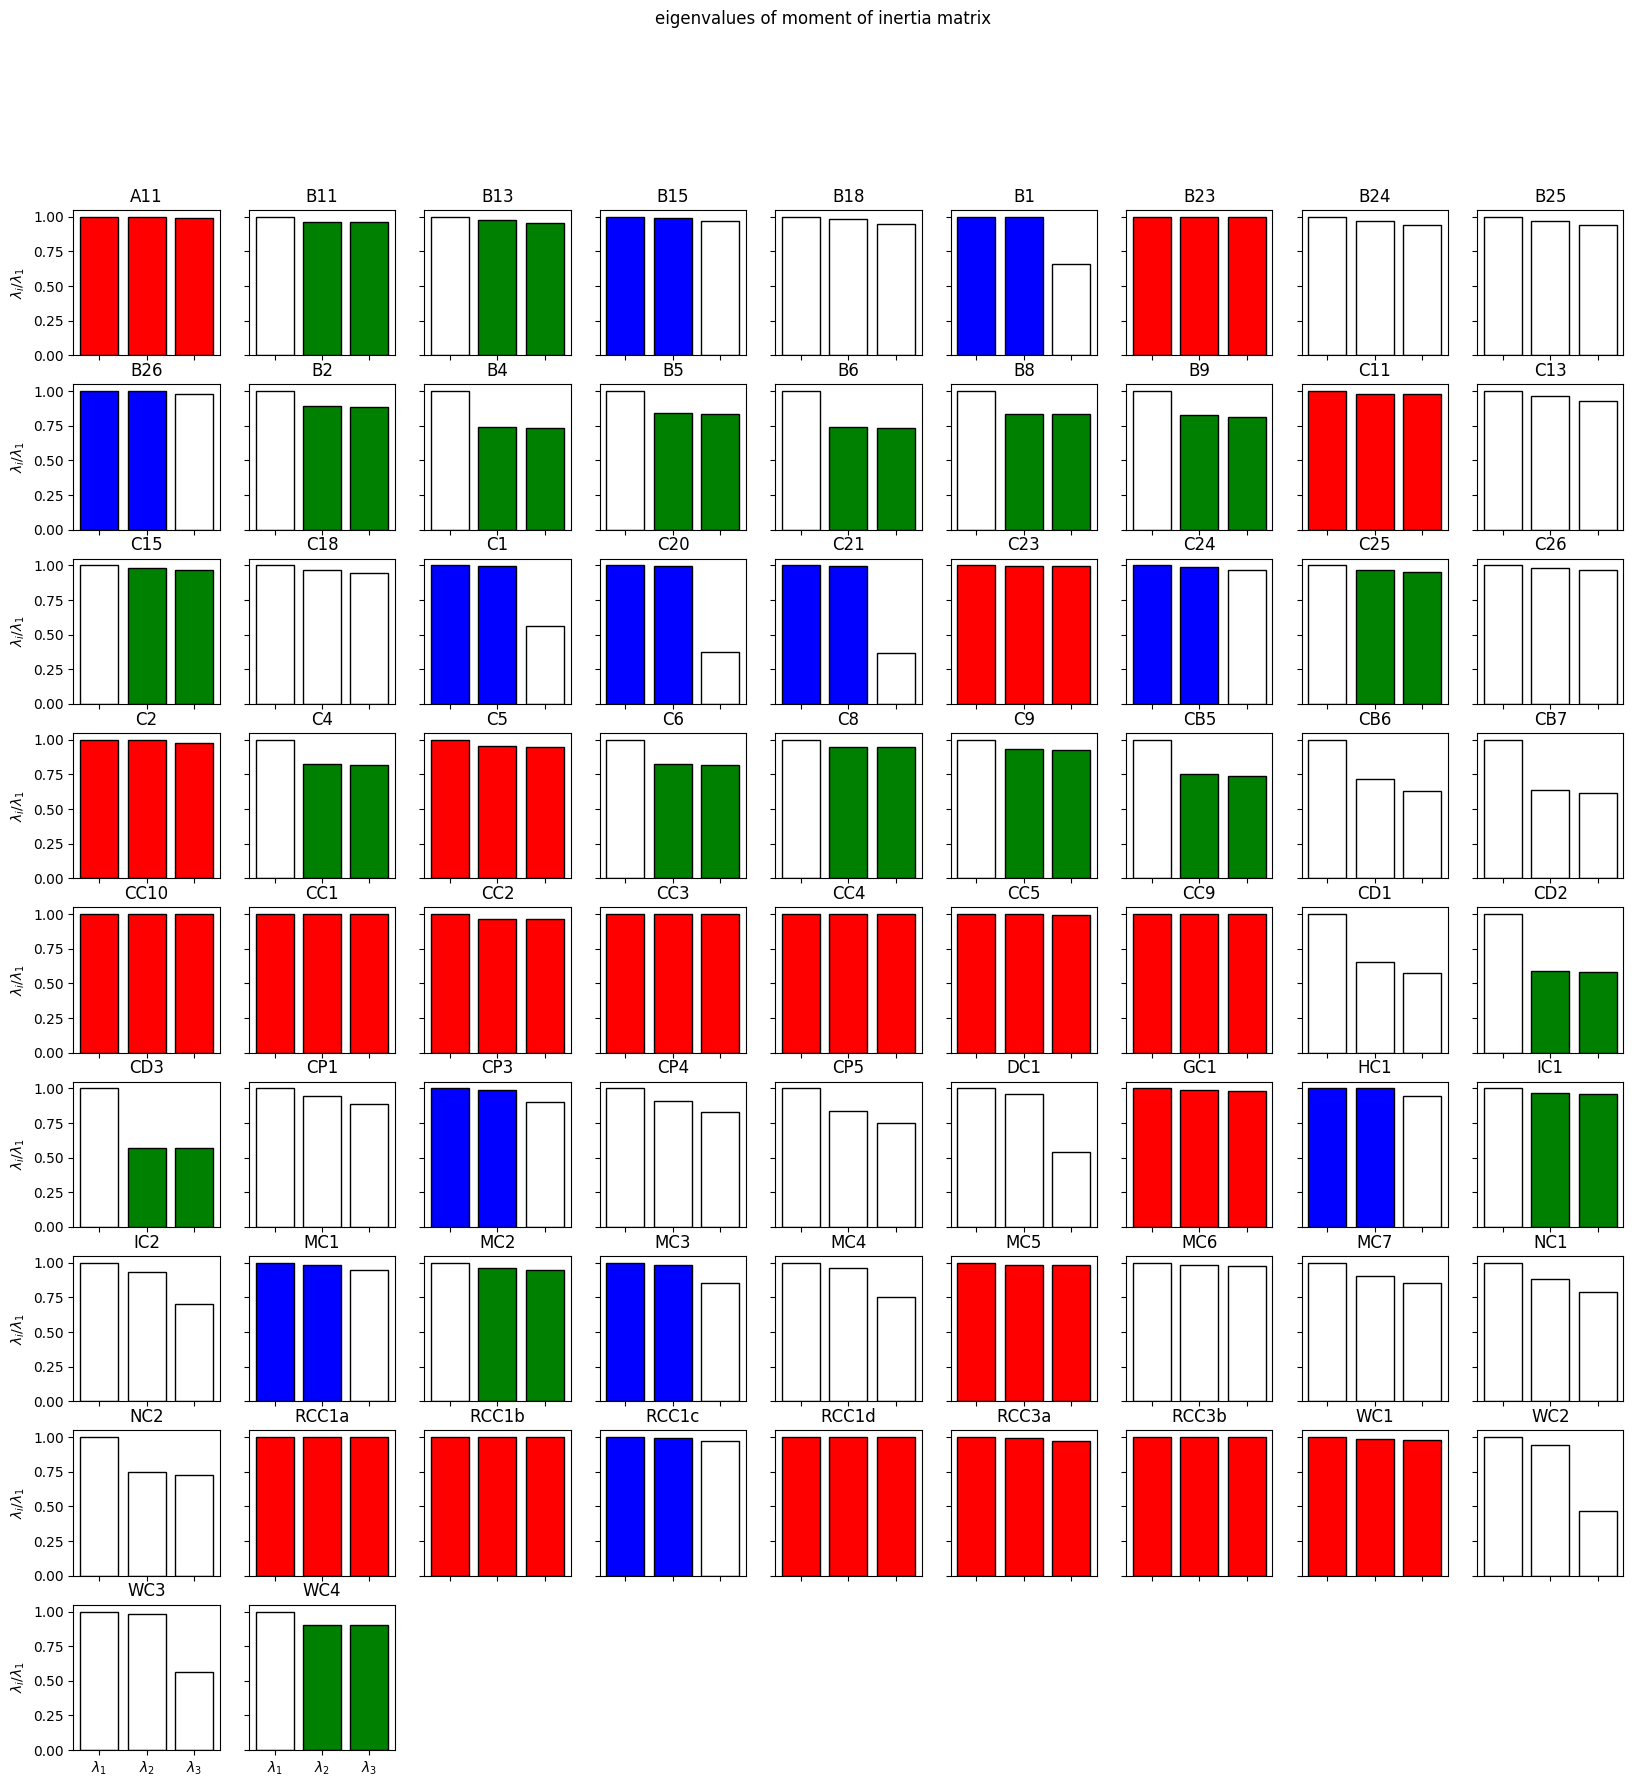

In [9]:
# list of cages that need alignment b/c principal axes of inertia agnostic
needs_alignment = Dict("xy" => String[], "yz" => String[], "xyz" => String[])

nrows = ceil(Int, sqrt(length(cages))) # in the big plot
fig, axs = plt[:subplots](nrows=nrows, ncols=nrows, figsize=(20, 20),
                          sharex=true, sharey=true)
cage_no = 0
for i = 1:nrows
    for j = 1:nrows
        cage_no += 1
        if cage_no > length(cages)
            axs[i, j][:axis]("off")
            continue
        end
        
        atoms, x = rotational_inertia_aligned_cage(cages[cage_no])
        write_xyz(atoms, x, 
            "all_cages/" * cages[cage_no] * "_rotational_inertia_aligned.xyz")

        λ, v, mi = diagonlize_moment_of_inertia(atoms, x)
        
        # coloring scheme
        colorz = ["w", "w", "w"]
        
        # can a few e.g. C atoms at the periphery throw off the moment of inertia?
        #  i.e. how sensitive is the alignment?
        cage_radius = maximum([norm(x[:, a]) for a = 1:size(x)[2]])
        Δλ_tol = 12.0 * cage_radius ^ 2
        xy_symmetry = isapprox(λ[1], λ[2], atol=Δλ_tol)
        yz_symmetry = isapprox(λ[2], λ[3], atol=Δλ_tol)
        if xy_symmetry && yz_symmetry
            push!(needs_alignment["xyz"], cages[cage_no])
            colorz[:] .= "r"
        elseif xy_symmetry
            push!(needs_alignment["xy"], cages[cage_no])
            colorz[1:2] .= "b"
        elseif yz_symmetry
            push!(needs_alignment["yz"], cages[cage_no])
            colorz[2:3] .= "g"
        end
       
        axs[i, j][:bar]([1, 2, 3], λ / λ[1], color=colorz, edgecolor="k")
        axs[i, j][:set_title](cages[cage_no])
        if j == 1
            axs[i, j][:set_ylabel]("\$ \\lambda_i / \\lambda_1\$")
        end
    end
end
plt[:xticks]([1, 2, 3], ["\$\\lambda_1\$", "\$\\lambda_2\$", "\$\\lambda_3\$"])
suptitle("eigenvalues of moment of inertia matrix")
savefig("moments_of_inertia.pdf", format="pdf")
show()

point set registration...

This function, given a reference cage, searches among a list of cages for the one with the closest alignment using the Coherent Drift algorithm. Then it aligns the cage.

In [10]:
function find_and_align_closest(ref_cage::AbstractString, 
                                unaligned_cages::Array{String, 1})
    # read in CPD-aligned cage. for absolute reference cage, this was written externally
    atoms_ref, x_ref = read_xyz("all_cages/" * ref_cage * "_cpd_aligned.xyz")
    
    # -ve log likelihoods
    ℓ = [Inf for i = 1:length(unaligned_cages)]
    
    # loop thru all other unaligned cages, see which is best aligned
    for (i, cage) in enumerate(unaligned_cages)
        if cage == ref_cage
            error("cage == ref cage...")
        end
        atoms, x = rotational_inertia_aligned_cage(cage)
        
        # transformation is applied not to reference cage but the unaligned cage!
        R, t, σ², ℓ[i] = CoherentPointDrift.rigid_point_set_registration(x_ref, x, 
            w=0.0, σ²_tol=0.1, verbose=false)
    end
    # which cage had the best alignment?
    i_closest = argmin(ℓ)
    @printf("Aligning ref. cage %s to %s...\n", ref_cage, 
        unaligned_cages[i_closest])
    
    # align it.
    atoms, x = rotational_inertia_aligned_cage(unaligned_cages[i_closest])
    R, t, σ², ℓ = CoherentPointDrift.rigid_point_set_registration(x_ref, x, 
            w=0.0, σ²_tol=0.1, verbose=false)
    
    # write result to file
    write_xyz(atoms, R * x, 
        "all_cages/" * unaligned_cages[i_closest] * "_cpd_aligned.xyz")
    
    return unaligned_cages[i_closest]
end

find_and_align_closest (generic function with 1 method)

In [ ]:
for alignment_plane in ["xyz", "xy", "yz"]
    has_been_aligned = [false for i = 1:length(needs_alignment[alignment_plane])]

    ref_cage = needs_alignment[alignment_plane][1]
    has_been_aligned[1] = true
    atoms, x = rotational_inertia_aligned_cage(ref_cage)
    # write CPD .xyz so it can be read in from find_and_align_closest.
    write_xyz(atoms, x, 
        "all_cages/" * ref_cage * "_cpd_aligned.xyz")
    @printf("\nAbsolute reference cage for %s aligned cages is %s\n", 
        alignment_plane, ref_cage)

    while sum(.! has_been_aligned) > 0
        ref_cage = find_and_align_closest(ref_cage, 
            needs_alignment[alignment_plane][.! has_been_aligned])

        # update alignment status
        has_been_aligned[needs_alignment[alignment_plane] .== ref_cage] .= true
    end
end


Absolute reference cage for xyz aligned cages is A11
Aligning ref. cage A11 to C11...
Aligning ref. cage C11 to MC5...
Aligning ref. cage MC5 to WC1...
Aligning ref. cage WC1 to GC1...
Aligning ref. cage GC1 to C23...
Aligning ref. cage C23 to B23...
Aligning ref. cage B23 to CC5...
Aligning ref. cage CC5 to RCC1b...
Aligning ref. cage RCC1b to CC10...
Aligning ref. cage CC10 to CC9...
Aligning ref. cage CC9 to RCC1a...
Aligning ref. cage RCC1a to CC3...
Aligning ref. cage CC3 to CC4...
Aligning ref. cage CC4 to RCC3b...
Aligning ref. cage RCC3b to RCC1d...
Aligning ref. cage RCC1d to RCC3a...
Aligning ref. cage RCC3a to CC2...
Aligning ref. cage CC2 to CC1...
Aligning ref. cage CC1 to C5...
Aligning ref. cage C5 to C2...

Absolute reference cage for xy aligned cages is B15
Aligning ref. cage B15 to MC1...
Aligning ref. cage MC1 to B26...
Aligning ref. cage B26 to C24...
Aligning ref. cage C24 to RCC1c...
Aligning ref. cage RCC1c to MC3...
Aligning ref. cage MC3 to HC1...
Aligning ref

Write .xyz files with final alignments to load in.

In [ ]:
for cage in cages
    final_aligned_filename = "all_cages/" * cage * "_final_aligned.xyz"
    
    aligned_by_coherent_drift = false
    for alignment_plane in ["xyz", "xy", "yz"]
        if cage in needs_alignment[alignment_plane][2:end] # not first b/c reference
            aligned_by_coherent_drift = true
        end
    end
    
    appropriate_xyz = "all_cages/" * cage
    if aligned_by_coherent_drift
        appropriate_xyz *= "_cpd_aligned.xyz"
        @printf("%s aligned by coherent drift algo\n", cage)
    else
        appropriate_xyz *= "_rotational_inertia_aligned.xyz"
        @printf("%s aligned by axes of inertia only\n", cage)
    end
    run(`cp $appropriate_xyz $final_aligned_filename`)
end

In [ ]:
aligned_and_centered_cage(cage::AbstractString) = read_xyz(cage * "_final_aligned.xyz")

## Generate 3D void space images
Superimpose a regular 3D grid of points centered at the cage center of mass. 
Compute the potential energy of a Helium probe at each grid point.
If the energy is less than a certain value, that point is declared "accessible".
Think of this as a CAT scan for cages!

Set up computation of potential energy of Helium probe in the cages

In [ ]:
he = Molecule("He")

rc = 14.0 # vdw cutoff radius
ljff = LJForceField("UFF.csv", cutoffradius=rc, mixing_rules="geometric");

Write padded .cif files of the cages for molecular simulations. 
In the same loop, determine what size of snapshot we need to encapsulate all cages.

In [ ]:
snapshot_dim = 0.0 # find max dimension we need for snapshot to include all atoms of all cages
biggest_cage = ""

for cage in cages
    # read in aligned and centered cage
    atoms, x = aligned_and_centered_cage(cage)
    # observe max dimension so we know size of snapshot to take.
    x_span = 2.0 * maximum(abs.(x))
    if x_span > snapshot_dim # 2 b/c centered at zero
        snapshot_dim = x_span
        biggest_cage = cage
    end
    
    #
    # write to .cif for molecular simulation
    #
    # make sure with PBCs no interactions are included by padding
    box = Box([x_span + 2 * rc for blah = 1:3]..., 
              [π/2 for blah = 1:3]...)
    # when writing .cif, shift coords so they are in [0, 1]^3
    #    so in .cif center of mass is center of box.
    x_shift = [x_span + 2 * rc for blah = 1:3] / 2.0
    framework = Framework(cage, box, 
                          Atoms(atoms, x), 
                          Charges(Array{Float64, 1}(undef, 0), Array{Float64, 2}(undef, 0, 0))
                          )
    write_cif(framework, 
        @sprintf("data/crystals/%s_aligned.cif", cage))
end

println("aligned and centered cages written to .xyz in all_cages/*_aligned.xyz")
println("see data/crystals for .cif's padded by rc for molecular simulations'")
println("Largest cage: :", biggest_cage)

In [ ]:
snapshot_dim = ceil(snapshot_dim)
println("Dimension of snapshot to fit all porous cages (Å): ", snapshot_dim)

const center_of_box = [snapshot_dim / 2.0 for d = 1:3]

const snapshot_box = Box(snapshot_dim, snapshot_dim, snapshot_dim, π/2, π/2, π/2)

Discretize space; `x_grid_pts` ranges from `-snapshot_dim` to `snapshot_dim` so it overlays the cage coordinates.

In [ ]:
const nb_grid_pts = 50
const x_grid_pts = collect(range(0, stop=snapshot_dim, length=nb_grid_pts)) .- snapshot_dim / 2.0

Build data matrix `A`, whose rows are the flattened snapshots of a particular cage.

In [ ]:
A = zeros(Float64, length(cages), nb_grid_pts ^ 3)

for (c, cage) in enumerate(cages)
    # read in aligned and centered cage
    atoms, x = aligned_and_centered_cage(cage)
    
    # assert snapshot box is big enough
    @assert(all(x .< maximum(x_grid_pts)) && all(x .> minimum(x_grid_pts)),
        "atoms outside snapshot!")
    
    # convert cage to a list of LJSphere's for PorousMaterials.jl
    ljspheres = Atoms(atoms, x)
    
    # preallocate grid; choose origin here solely for visualization
    # when we write to a .cube file. the origin passed to `Grid`
    # is so the cage is centered at the origin in the viz. (checked)
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                zeros(Float64, nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                :accessibility, -center_of_box)
        
    for i = 1:nb_grid_pts, j = 1:nb_grid_pts, k = 1:nb_grid_pts
        # what grid pt is here inside the loop?
        x_grid_pt = [x_grid_pts[i], x_grid_pts[j], x_grid_pts[k]]
        
        # put helium at this grid pt
        translate_to!(he, x_grid_pt)
        
        # compute potential energy of He adsorbate here
        energy = vdw_energy_no_PBC(he, ljspheres, ljff)
        
        # if framework atom overlaps with cage atom... energy > k T
        if energy > 298.0
            grid.data[i, j, k] = 1.0
        end
    end
    
    # save grid for visualization
    write_cube(grid, cages[c] * ".cube", verbose=false)
    
    # add flattened grid as a row of the matrix `A`
    A[c, :] = grid.data[:]
    
    # assert that we can recover the snapshot by reshaping the rows of A
    @assert(isapprox(
            reshape(A[c, :], (nb_grid_pts, nb_grid_pts, nb_grid_pts)),
            grid.data)
           )
end

println("see data/grids for .cube visualizations of the cage scans")
size(A)

Look at rank of $A$. Do any two cages have the same representation?


In [ ]:
println("rank of A: ", rank(A))
for i = 1:length(cages)
    for j = (i+1):length(cages)
        if norm(A[i, :] - A[j, :]) < 5.0
            @printf("Cages %s and %s hv same raw representation!", cages[i], cages[j])
        end
    end
    # just in case...
    if all(A[i, :] .== 0.0) || all(A[i, :] == 1.0)
        println("Cage is all zeros or all ones! ", cages[i])
    end
end

Compute the average cage.

In [ ]:
average_cage = zeros(Float64, nb_grid_pts ^ 3)
for c = 1:length(cages)
    average_cage += A[c, :]
end
average_cage /= length(cages)

# write to .cube
grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
            reshape(average_cage, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
            :accessibility, -center_of_box)

write_cube(grid, "average_cage.cube")
@printf("%d/%d pixels nonzero in average cage\n", sum(average_cage .!= 0), length(average_cage))

Subtract off the average cage from each cage.

In [ ]:
for c = 1:length(cages)
    A[c, :] = A[c, :] - average_cage
end

At this point, if $\mathbf{x_i}$ is a feature vector (a row of `A`), then $\sum_i \mathbf{x_i} = \mathbf{0}$. See [here](https://epubs.siam.org/doi/pdf/10.1137/S0036144501387517).

In [ ]:
x_sum = zeros(nb_grid_pts ^ 3)
for c = 1:length(cages)
    x_sum += A[c, :]
end
@assert(all(isapprox.(x_sum, zeros(nb_grid_pts ^ 3), atol=1e-5)))

Visualize the matrix (half of a joke)

In [ ]:
matshow(A)
yticks([0, length(cages)-1])
tight_layout()
savefig("data_matrix_viz.png", format="png", dpi=300, bbox_inches="tight")

How many columns are all zeros?

In [ ]:
sum(sum(abs.(A), dims=1) .== 0.0)

In [ ]:
rank(A)

Perform the SVD decomposition of the data matrix

In [ ]:
UΣVᵀ = svd(A)

println("size of U: ", size(UΣVᵀ.U))
println("# singular values: ", length(UΣVᵀ.S))
println("size of Vᵀ: ", size(UΣVᵀ.Vt))

@assert(isapprox(A, UΣVᵀ.U * diagm(0 => UΣVᵀ.S) * UΣVᵀ.Vt))

In [ ]:
figure()
plt[:hist](UΣVᵀ.S, color="g")
xlabel("singular value")
ylabel("# singular values")
xlim(xmin=0)
savefig("distn_of_svs.png", format="png", dpi=300)

figure()
plot(1:length(UΣVᵀ.S), UΣVᵀ.S, color="g", marker="o")
xlabel("\$i\$")
ylabel("singular value \$\\sigma_i\$")
title("Ranked singular values")
savefig("svs_ordered.png", format="png", dpi=300)

ratio of norm of error to norm of $A$.
See pg. 19 of 
> A Singularly Valuable Decomposition: The SVD of a Matrix. Dan Kalman

In [ ]:
relative_err = 1.0 .- sqrt.([sum(UΣVᵀ.S[1:i] .^ 2) for i = 1:length(UΣVᵀ.S)] / sum(UΣVᵀ.S .^ 2))
relative_err = vcat([1.0], relative_err)

fig = figure()
xlabel("Rank of approximation, \$\\nu\$")
ylabel("relative error \$||\\mathbf{A}-\\mathbf{A}_\\nu||_F/||\\mathbf{A}||_F \$")
plot(0:length(UΣVᵀ.S), relative_err, marker="o")
savefig("relative_err_with_svs.png", format="png", dpi=300)

Take the latent space as a composition of the first `r` singular vectors.
Select `r` so that we recover a certain fraction of the energy, `fraction_energy_recovered`.

In [ ]:
# assert singular values are sorted
@assert(sortperm(UΣVᵀ.S) == reverse([i for i = 1:length(UΣVᵀ.S)]))

desired_relative_err = 0.15
ν = findfirst(relative_err .< desired_relative_err) # number of singular values to include

@printf("%d singular values results in relative error %f; setting latent dim = %d.\n",
    ν, relative_err[ν], ν)

x_latent = UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν])
@assert(isapprox(x_latent, A * UΣVᵀ.V[:, 1:ν]), "UΣ != AV")
@assert(size(x_latent) == (length(cages), ν))

use t-SNE to embed latent representation in 2D

In [ ]:
Random.seed!(1234)
x_tsne = tsne(x_latent, 2, 0, 100000, 5.0);
size(x_tsne)

write 2D t-SNE latent dim to file for D3 interactive viz

In [ ]:
latent_dim_file = open("latent_dim.csv", "w")
@printf(latent_dim_file, "cage_image,x1,x2\n")
for (c, cage) in enumerate(cages)
    @printf(latent_dim_file, "%s_aligned.png,%f,%f\n", cage, x_tsne[c, :]...)
end
close(latent_dim_file)

In [ ]:
figure(figsize=(7, 7))
scatter(x_tsne[:, 1], x_tsne[:, 2], color="g")
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
texts = []
for i = 1:length(cages)
    push!(texts,
        annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
xlabel("latent dim. 1")
ylabel("latent dim. 2")
axis("equal")
title("latent cage space")
tight_layout()
savefig("latent_cage_space_2D.pdf", format="pdf", dpi=300)
show()

... t-SNE to embed in 3D

In [ ]:
x_tsne_3D = tsne(x_latent, 3, 0, 10000, 5.0);

figure()
scatter3D(x_tsne_3D[:, 1], x_tsne_3D[:, 2], x_tsne_3D[:, 3])
show()

## Correlation between latent space and cage descriptors from `pywindow`

Crude cage size descriptors:

* `molecule_diameter`: if we could stuff the cage molecule into a sphere, how big would the sphere need to be?
* `void_diameter`: distance between center of mass of the molecule and the closest atom, corrected for appropriate vdW radii and multiplied by 2.

See:

> M. Miklitz, S. Jiang, R. Clowes, M. E. Briggs, A. I. Cooper and K. E. Jelfs, Computational Screening of Porous Organic Molecules for Xenon/Krypton Separation, J. Phys. Chem. C, 2017, 121, 15211–15222.

We computed these from `pywindow`:

> M. Miklitz, K. E. Jelfs. pywindow: Automated Structural Analysis of Molecular Pores. ChemRxiv.

(checked WC3 in Table 1 for correspondence of those we computed.) See `cage_descriptors.ipynb`.

In [ ]:
df_descriptors = CSV.read("pywindow_cage_descriptors.csv")
head(df_descriptors)

Put in an array with same order as `cages` for easy plotting

In [ ]:
pore_diameters = zeros(length(cages))
molecule_diameters = zeros(length(cages))
nb_windows = zeros(Int, length(cages))
for (i, cage) in enumerate(cages)
    idx_this_cage = df_descriptors[:cage] .== cage
    @assert(sum(idx_this_cage) == 1, @sprintf("%s not found in df_descriptors (or multiple)!", cage))
    pore_diameters[i] = df_descriptors[idx_this_cage, :pore_diameter_A][1]
    molecule_diameters[i] = df_descriptors[idx_this_cage, :molecule_diameter_A][1]
    nb_windows[i] = df_descriptors[idx_this_cage, :nb_windows][1]
end

Visualize distribution of descriptors among the cages.

In [ ]:
figure()
plt[:hist](pore_diameters, color="b", alpha=0.2, label="cavity")
plt[:hist](molecule_diameters, color="r", alpha=0.2, label="molecule")
legend()
xlabel("diameter (Å)")
ylabel("# cages")
savefig("pywindow_descriptors_distn.png", format="png", dpi=300)

Visualize distribution of the number of windows

In [ ]:
fig = figure()
plt[:hist](nb_windows, bins=0:10)
xlabel("# of windows into cavity")
ylabel("# of cages")

Assess if clustering picks on up the descriptors.
Color according to pore diameters, make size according to molecule diameter.
the marker size is the area, so we should make the size on the order of `molecule_diameter^2`.

In [ ]:
figure(figsize=(8, 7))
scatter(x_tsne[:, 1], x_tsne[:, 2],
    c=pore_diameters,
    s=molecule_diameters .^ 2 / maximum(molecule_diameters .^ 2) * 35.0,
    vmax=15.0
)
texts = []
for i = 1:length(cages)
    push!(texts,
        annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
cbar = colorbar(extend="max", label="cavity diameter (Å)")
title("latent cage space")
xlabel("latent dim. 1")
ylabel("latent dim. 2")
axis("equal")
tight_layout()
savefig("cage_space_colored_by_diams_2D.png", format="png", dpi=300)
show()

hypothesis that first eigencage picks up the pore size.

In [ ]:
fig = figure()
scatter(pore_diameters, UΣVᵀ.U[:, 1] * UΣVᵀ.S[1], color="C1")
xlabel("cavity diameter (Å)")
ylabel("first component of latent representation")
savefig("first_component_captures_pore_diameter.pdf", format="pdf")

Assess if clustering picks up on # windows 

In [ ]:
cmap = get_cmap("Pastel1", maximum(nb_windows) - minimum(nb_windows)+1)

figure(figsize=(8, 7))
scatter(x_tsne[:, 1], x_tsne[:, 2],
    c=nb_windows, cmap=cmap, vmin=minimum(nb_windows)-0.5, vmax=maximum(nb_windows)+0.5
)
texts = []
for i = 1:length(cages)
    push!(texts,
        annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
#cbar = plt.colorbar(extend="max", label="cavity diameter (Å)")
title("latent cage space")
xlabel("latent dim. 1")
ylabel("latent dim. 2")
axis("equal")
colorbar(label="# of windows to cavity")
tight_layout()
savefig("cage_space_colored_by_nb_windows.png", format="png", dpi=300)
show()

In [ ]:
fig = figure(figsize=(8, 7))
ax = fig[:add_subplot](111, projection="3d")

ax[:scatter](x_tsne_3D[:, 1], x_tsne_3D[:, 2], x_tsne_3D[:, 3],
    c=pore_diameters,
    s=molecule_diameters .^ 2 / maximum(molecule_diameters .^ 2) * 35.0,
    vmax=15.0)
for i = 1:length(cages)
    ax[:text](x_tsne_3D[i, 1], x_tsne_3D[i, 2], x_tsne_3D[i, 3], cages[i])
end
xlabel("latent dim. 1")
ylabel("latent dim. 2")
zlabel("latent dim. 3")
title("latent cage space")
tight_layout()
savefig("cage_space_colored_by_diams_3D.png", format="png", dpi=300)
show()

### Visualize the eigen-cages
i.e. discovered concepts, which are the rows of $\mathbf{V}^T$.

In [ ]:
for concept_id = 1:ν
    x_concept = transpose(UΣVᵀ.V)[concept_id, :] # flattened
    x_concept = reshape(x_concept, (nb_grid_pts, nb_grid_pts, nb_grid_pts))

    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                reshape(x_concept, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
                :accessibility, -center_of_box)

    write_cube(grid, @sprintf("eigencage%d.cube", concept_id))
end

### reconstruct a material as singular values are added

In [ ]:
which_cage = "B25"
cage_id = findfirst(cages .== which_cage)

for sv = 1:14
    # approximate matrix
    A_ν = UΣVᵀ.U[:, 1:sv] * diagm(0 => UΣVᵀ.S[1:sv]) * transpose(UΣVᵀ.V[:, 1:sv])
    # reconstruction
    x = A_ν[cage_id, :] .+ average_cage
    
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
            reshape(x, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
            :accessibility, -center_of_box)

    write_cube(grid, @sprintf("%s_reconstructed_%dsvs.cube", which_cage, sv))
end

### Compare latent space with Henry coefficients
From Melanie: UFF, 14 A cutoff, geometric mixing rules, 298.0 K

In [ ]:
dfs = Dict{String, DataFrame}()
for gas in ["He", "Kr", "Xe"]
    dfs[gas] = CSV.read("henry_coefs/" * gas * "_cage_KH.csv")
end
dfs["He"]

In [ ]:
df_new = DataFrame(cage=String[], KH_Xe=Float64[], KH_Kr=Float64[])
for row in eachrow(dfs["Xe"])
    kh_he = dfs["He"][dfs["He"][:cage] .== row[:cage], 
        Symbol("KH_mol/(m³-bar)")][1]
    kh_kr = dfs["Kr"][dfs["Kr"][:cage] .== row[:cage], 
        Symbol("KH_mol/(m³-bar)")][1]
    push!(df_new, [row[:cage], row[Symbol("KH_mol/(m³-bar)")] - kh_he, kh_kr - kh_he])
end
df_new[:Xe_Kr_selectivity] = df_new[:KH_Xe] ./ df_new[:KH_Kr]
head(df_new)

In [ ]:
S_Xe_kr = [df_new[df_new[:cage] .== cage * "_aligned.cif", 
        :Xe_Kr_selectivity][1] for cage in cages][:]

In [ ]:
figure(figsize=(8, 7))
scatter(x_tsne[:, 1], x_tsne[:, 2],
    s=35,
    c=S_Xe_kr,
    norm=PyPlot.matplotlib[:colors][:LogNorm](),
    cmap="plasma"
)
texts = []
for i = 1:length(cages)
    push!(texts,
        annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
cbar = colorbar(extend="max", label="simulated Xe/Kr selectivity")
title("latent cage space")
xlabel("latent dim. 1")
ylabel("latent dim. 2")
axis("equal")
tight_layout()
savefig("cage_space_colored_by_S_Xe_Kr.png", format="png", dpi=300)
show()

Compare Henry coefficients to experimental data for noria and CC3

Noria data from: 10.1002/chem.201602131
CC3 data from: Fig 2c of DOI 10.1038/nmat4035 (plot digitized, sorry for noise; it is on a log scale)

In [ ]:
df_expt = Dict("noria" => Dict("Xe" => CSV.read("noria/Xe_expt_298K.csv"),
                               "Kr" => CSV.read("noria/Kr_expt_298K.csv")
                               ),
               "CC3"   => Dict("Xe" => CSV.read("cc3/Xe_expt_298K.csv"),
                               "Kr" => CSV.read("cc3/Kr_expt_298K.csv")
                               )
               )

In [ ]:
gas_colorz = Dict("Xe" => "C1", "Kr" => "C2")
markerz = Dict("Xe" => "s", "Kr" => "s")
xtal_name = Dict("noria" => "NC2_aligned.cif", "CC3" => "CC3_aligned.cif")

for cage in ["noria", "CC3"]
    fig = figure()
    xlabel("pressure (bar)")
    ylabel("gas uptake (mmol/g)")
    
    P = collect(range(0, stop=1, length=50))
    KH_He =  dfs["He"][dfs["He"][:cage] .== xtal_name[cage], Symbol("KH_mmol/(g-bar)")][1]
    for gas in ["Xe", "Kr"]
        # plot experimental data
        if cage == "noria"
            df_expt[cage][gas][Symbol("P(bar)")] = df_expt[cage][gas][Symbol("P(torr)")] * 0.00133322
        end
        scatter(df_expt[cage][gas][Symbol("P(bar)")], 
                    df_expt[cage][gas][Symbol("L(mmol/g)")], label=gas,
                    color=gas_colorz[gas], marker=markerz[gas])
        
        # grab simulated henry coeff and plot resulting henry's law
        KH =  dfs[gas][dfs[gas][:cage] .== xtal_name[cage], Symbol("KH_mmol/(g-bar)")][1]
        nH = (KH - KH_He) * P
        idx_keep = nH .< 1.0
        plot(P[idx_keep], nH[idx_keep], color=gas_colorz[gas])
    end
    title(cage)
    legend()
    tight_layout()
    savefig(cage * "_expt_sim_comparison.png", format="png")
end

## A walk through latent space

In [ ]:
cage_i = "DC1"
cage_j = "CC9"

idx_i = findfirst(cages[:] .== cage_i)
idx_j = findfirst(cages[:] .== cage_j)

x_latent_i = (UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν]))[idx_i, :]
x_latent_j = (UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν]))[idx_j, :]
# c is interpreting parameter
for c in 0.0:0.2:1.0
    x_latent_fictitious = c * x_latent_i + (1 - c) * x_latent_j
    x_fictitious = x_latent_fictitious' * UΣVᵀ.V[:, 1:ν]'
    x_fictitious = x_fictitious' # back to column vector
    # add average cage
    x_fictitious = x_fictitious + average_cage
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
               reshape(x_fictitious, (nb_grid_pts, nb_grid_pts, nb_grid_pts)),
               :accessibility, -center_of_box)
    write_cube(grid, @sprintf("%s_%s_interpolation_c_%.2f.cube", cage_i, cage_j, c))
end

## Radar plots 
(cool was to visualize a high-dimensional representation but not used in the paper)

In [ ]:
function draw_radar_plot(x::Array{Float64, 1})
    n_dims = length(x)
    angles = range(0, stop = 2 * π, length = n_dims + 1)[1:end-1]
    # make periodic
    x = vcat(x, [x[1]])
    angles = vcat(angles, [angles[1]])
    labels = ["c$i" for i = 1:n_dims]
    
    fig = figure()
    ax = fig[:add_subplot](111, polar=true)
    ax[:grid](true)
    ax[:set_thetagrids](angles * 180.0 / π, labels)  # Set the label for each axis
    ax[:plot](angles, x, "-o", linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax[:fill](angles, x, alpha=0.25)  #Fulfill the area
end

function draw_radar_plot(x::Array{Float64, 2})
    n_dims = size(x)[2]
    angles = range(0, stop = 2 * π, length = n_dims + 1)[1:end-1]
    # make periodic
    angles = vcat(angles, [angles[1]])
    labels = ["c$i" for i = 1:n_dims]
    
    fig = figure()
    ax = fig[:add_subplot](111, polar=true)
    ax[:grid](true)
    ax[:set_thetagrids](angles * 180.0 / π, labels)  # Set the label for each axis
    for i = 1:size(x)[1]
        x_viz = vcat(x[i, :], [x[i, 1]])
        ax[:plot](angles, x_viz, "-o", linewidth=0.5)  # Draw the plot (or the frame on the radar chart)
        # ax[:fill](angles, x_viz, alpha=0.25)  #Fulfill the area
    end
    @warn "think this might beed to be transpose"
end

draw_radar_plot(x_latent[1, 1:5])
draw_radar_plot(x_latent[1, :])
draw_radar_plot(x_latent)
#ax.set_rlim(0,250)